# $\longrightarrow$ LIE GROUP REPRESENTATION ESTIMATION $\longleftarrow$

Lie-PCA paper: https://arxiv.org/pdf/2008.04278.pdf

Henrique thesis: https://www.overleaf.com/project/629a2646158ff1593e76807d

**Note:** Our algorithm may not converge every time, therefore it may be necessary to run it multiple times to obtain satisfactory results. This is due to the possibility of getting stuck in local minimum, while using the *Stiefel* of *Grassmann* method.

# Functions

In [1]:
import liedetect
import sklearn, scipy
import matplotlib.pyplot as plt

C:\Users\hlovi\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\hlovi\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\hlovi\Anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\hlovi\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Experiments I - Torus

## I-1: Representation of $\mathrm{SO}(2)$

### I-1-a: Representation of $\mathrm{SO}(2)$ in $\mathbb{R}^4$

We start with a simple example: a representation of $\mathrm{SO}(2)$ in dimension $4$.
Our goal is to recover the frequencies of the representation. We first generate the point cloud.

-----> Representation of T^1 in R^4
frequencies: ((1, 2),)


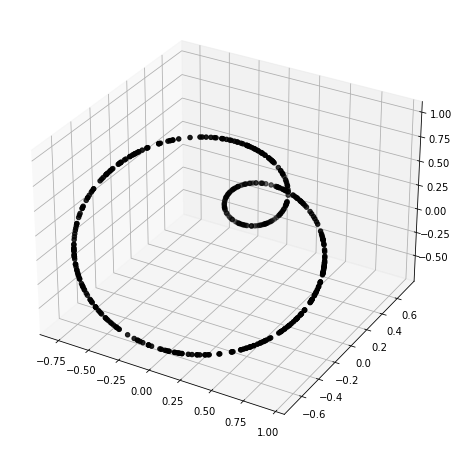

In [2]:
' Generate dataset '

# Parameters
ambient_dim = 4     # ambient dimension
dim = 1             # dimension of the torus (here, circle)
n_points = 500      # number of sample points
frequency_max = 4   # maximal angle parameter

# Generate dataset and plot
X, LieAlgebra = liedetect.datasets.SampleOnTorus(dim=dim, ambient_dim=ambient_dim, n_points=n_points, frequency_max=frequency_max,
                              conjugate=True,right_multiply=True,verbose=True)
Xpca = sklearn.decomposition.PCA(n_components=3).fit_transform(X)
fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');

Next, we apply Lie-PCA. Two methods are available: with local covariance, that do not use pruning of the eigenvectors, and with local PCA, that does. On both methods, we already see that the Lie-PCA operator has one significantly small eigenvalue. This is an indicator of the fact that the underlying orbit is generated by $\mathrm{SO}(2)$.

In [3]:
' Lie-PCA '

n_neighbors = 10
method='localcovariance'
Sigma = liedetect.lie_optimization.GetLiePCAOperator(X,n_neighbors,ambient_dim,dim=dim,method=method)

method='localPCA'
Sigma = liedetect.lie_optimization.GetLiePCAOperator(X,n_neighbors,ambient_dim,dim=dim,method=method)

----> Lie PCA with localcovariance estimation of tangent spaces <----
First eigenvalues: [0.00024053534255154274, 0.1107909520320443, 0.11803854805424605, 0.12438883207069876]
----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [6.756257425633017e-05, 0.11254958767244483, 0.11901848285091857, 0.1256052630898747]


We now find the Lie algebra more likely to generate the orbit underlying the point cloud, based on the Lie-PCA operator. 
To this end, we implemented three methods: one consists in an optimisation on $\mathrm{O}(n)\times\mathrm{O}(d)$, one on $\mathrm{O}(n)$, and the last one is based in the normal form decomposition of the skew-symmetric matrices.
We see that the three methods allow to recover exactly the frequencies, and give an accurate estimation of the underlying orbit.

----> Optimization problem via Stiefel <----
Frequencies ((1, 2),) - result 1.3538194064649947e-07
Frequencies ((1, 3),) - result 0.0012318075400838684
Frequencies ((1, 4),) - result 0.0026033035647232976
Frequencies ((2, 3),) - result 0.000950605297700379
Frequencies ((3, 4),) - result 0.001983955293345503
The optimal frequencies found is  ((1, 2),) with cost  1.3538194064649947e-07
Non-symmetric Hausdorff distance from X to estimated orbit: 0.033369529022857836 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.04206796476412178


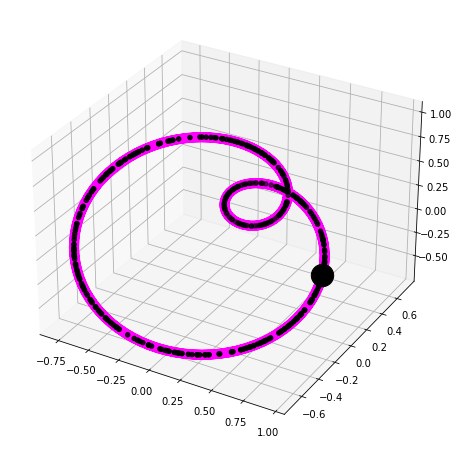

----> Optimization problem via Grassmann <----
Frequencies ((1, 2),) - result 6.35527814019345e-07
Frequencies ((1, 3),) - result 0.04031628513634067
Frequencies ((1, 4),) - result 0.09459571441360436
Frequencies ((2, 3),) - result 0.03049233023352839
Frequencies ((3, 4),) - result 0.06360374624626013
The optimal frequencies found is ((1, 2),) with cost 6.35527814019345e-07
Non-symmetric Hausdorff distance from X to estimated orbit: 0.0332763890353355 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.04108303236635642


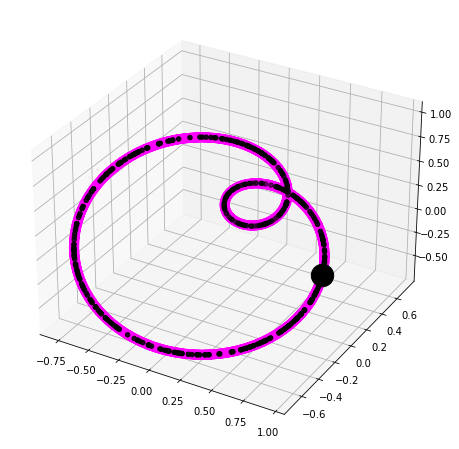

----> Optimization problem via NormalForm <----
Frequencies in normal form decomposition: (0.44771771797220583, 0.8941749521283632)
The optimal frequencies found is  ((1, 2),) with cost  0.0005637055218352104
Non-symmetric Hausdorff distance from X to estimated orbit: 0.033276359480926644 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.04108298659943541


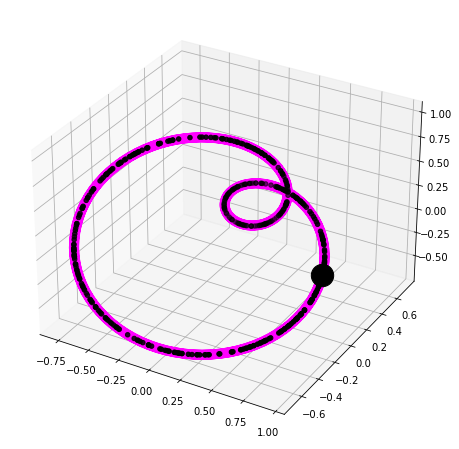

In [4]:
' Project on Lie subalgebras '

for method in ['Stiefel', 'Grassmann', 'NormalForm']:

    OptimalFrequencies, OptimalLieAlgebra = liedetect.lie_optimization.FindClosestLieAlgebra(Sigma,dim,ambient_dim,frequency_max=frequency_max,
                                                                  method=method,verbosity=1)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 150
    x = X[0,:] #initial point of X
    Orbit = liedetect.lie_optimization.GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, 
                                                          n_points_orbit, x, dim)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

    # Plot dataset
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=10); plt.show()

### I-1-b: Representation of $\mathrm{SO}(2)$ in $\mathbb{R}^6$

We reproduce the same experiment, $\mathrm{SO}(2)$ being now represented in dimension $6$.

-----> Representation of T^1 in R^6
frequencies: ((1, 2, 3),)


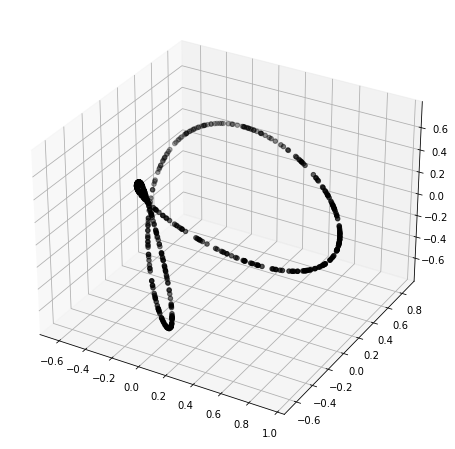

In [5]:
' Generate dataset '

# Parameters
ambient_dim = 6     # ambient dimension
dim = 1             # dimension of the torus (here, circle)
n_points = 500      # number of sample points
frequency_max = 3   # maximal angle parameter

# Generate dataset and plot
X, LieAlgebra = liedetect.datasets.SampleOnTorus(dim=dim, ambient_dim=ambient_dim, n_points=n_points, 
                                                 frequency_max=frequency_max, conjugate=True,right_multiply=True,verbose=True)
Xpca = sklearn.decomposition.PCA(n_components=3).fit_transform(X)
fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');

In [7]:
' Lie-PCA '

n_neighbors = 5
method='localcovariance'
Sigma = liedetect.lie_optimization.GetLiePCAOperator(X,n_neighbors,ambient_dim,dim=dim,method=method)

method='localPCA'
Sigma = liedetect.lie_optimization.GetLiePCAOperator(X,n_neighbors,ambient_dim,dim=dim,method=method)

----> Lie PCA with localcovariance estimation of tangent spaces <----
First eigenvalues: [0.0001880875333254286, 0.054892613339350846, 0.059379358989941636, 0.07560842709700324]
----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [8.142334318468297e-05, 0.05507636109110133, 0.059693282682046094, 0.07606667260967759]


----> Optimization problem via Stiefel <----
There are 1 frequencies to test.
Frequencies ((1, 2, 3),) - result 0.00404086794178289
(Terminated - min grad norm reached after 127 iterations, 15.67 seconds.)
The optimal frequencies found is  ((1, 2, 3),) with cost  0.00404086794178289
Non-symmetric Hausdorff distance from X to estimated orbit: 1.2337080703508025 
Non-symmetric Hausdorff distance from estimated orbit to X: 1.0441055296425195


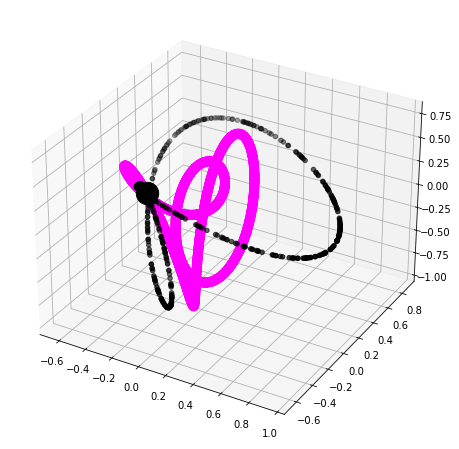

----> Optimization problem via Grassmann <----
There are 1 frequencies to test.
Frequencies ((1, 2, 3),) - result 5.073370543478608e-07
(Terminated - min grad norm reached after 108 iterations, 32.43 seconds.)
The optimal frequencies found is ((1, 2, 3),) with cost 5.073370543478608e-07
Non-symmetric Hausdorff distance from X to estimated orbit: 0.045743577022039454 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.06901300740984094


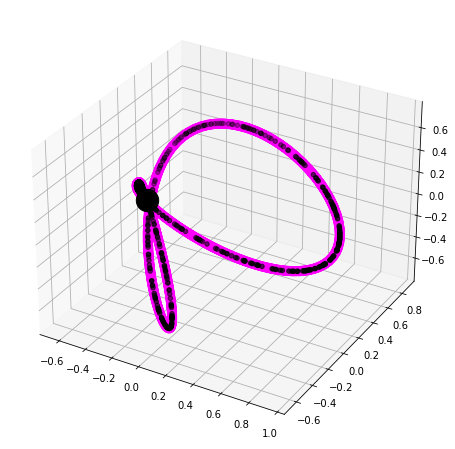

----> Optimization problem via NormalForm <----
Frequencies in normal form decomposition: (0.2675406436460512, 0.5348220622858855, 0.8014907146622031)
The optimal frequencies found is  ((1, 2, 3),) with cost  0.0005036547162337245
Non-symmetric Hausdorff distance from X to estimated orbit: 0.04574484252404386 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.06901208434699035


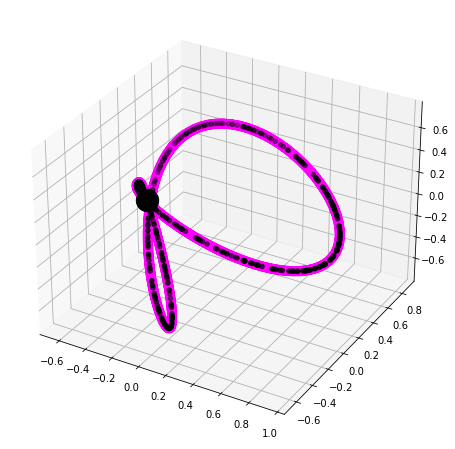

In [8]:
' Project on Lie subalgebras '

for method in ['Stiefel', 'Grassmann', 'NormalForm']:
    OptimalFrequencies, OptimalLieAlgebra = liedetect.lie_optimization.FindClosestLieAlgebra(Sigma,dim,ambient_dim,
                                                                                             frequency_max=frequency_max,
                                                                                             method=method,verbosity=2)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 150
    x = X[0,:] #initial point of X
    Orbit = liedetect.lie_optimization.GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points_orbit, x, dim)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

    # Plot dataset
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=10); plt.show()

### I-1-c: PCA pre-processing

The consistency of our method is based on the assumption that the underlying orbit lives in a minimal-dimensional subspace. If not, the isometry group $\mathrm{Isom}(\mathcal{O})$ is not equal to the symmetry group $\mathrm{Sym}(\mathcal{O})$, and our algorithm may return inconsistent Lie algebras.
This is the case for the point cloud below.

-----> Representation of T^1 in R^6
frequencies: ((1, 2, 3),)


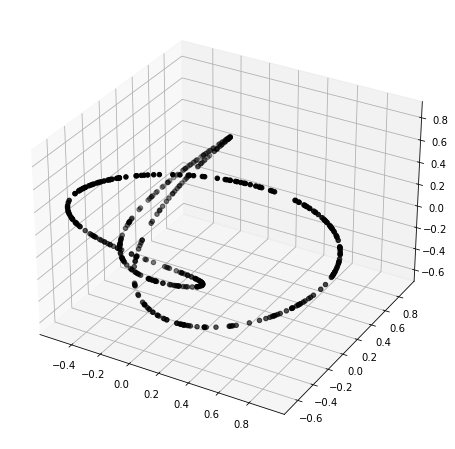

In [53]:
' Generate dataset '

# Parameters
ambient_dim = 6       # ambient dimension
dim = 1               # dimension of the torus (here, circle)
n_points = 500        # number of sample points
frequencies = ((1,1,2),) # prescribed frequencies

# Generate dataset and plot
X, LieAlgebra = SampleOnTorus(dim=dim, ambient_dim=ambient_dim, n_points=n_points, frequency_max=frequency_max,
                              conjugate=False,right_multiply=False,verbose=True)
Xpca = sklearn.decomposition.PCA(n_components=3).fit_transform(X)
fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');

In [54]:
' Lie-PCA '

n_neighbors = 5
method='localcovariance'
Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

# method='localPCA'
# Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

----> Lie PCA with localcovariance estimation of tangent spaces <----
First eigenvalues: [0.00020336893640533456, 0.055403393434648486, 0.059018445887377556, 0.07053707839572904]


----> Optimization problem via Stiefel <----
Frequencies ((1, 2, 3),) - result 0.0043279426824418665
The optimal frequencies found is  ((1, 2, 3),) with cost  0.0043279426824418665
Non-symmetric Hausdorff distance from X to estimated orbit: 1.2600588068907663 
Non-symmetric Hausdorff distance from estimated orbit to X: 1.0715354738672471


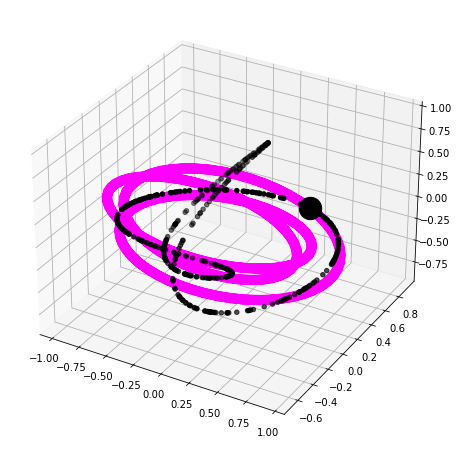

In [55]:
' Project on Lie subalgebras '

for method in ['Stiefel']:

    OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(Sigma,dim,ambient_dim,frequency_max=frequency_max,
                                                                  method=method,verbosity=1)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 150
    x = X[0,:] #initial point of X
    Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

    # Plot dataset
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=10); plt.show()

In order to remedy to this problem, we project the point cloud in a minimal-dimensional subspace.
Applying our algorithm again gives accurate results.

In [56]:
' Project in minimal-dimensional subspace '

# Prune small PCA eigenvalues
eps_pca = 1e-10
pca = sklearn.decomposition.PCA(n_components=ambient_dim); pca.fit(X)
dim_pca = sum(pca.explained_variance_ratio_>eps_pca)
print('Projection in dimension', dim_pca, '- PCA eigenvalues:', sorted(pca.explained_variance_ratio_))

# Dimension reduction via PCA
pca = sklearn.decomposition.PCA(n_components=dim_pca); 
X = pca.fit_transform(X)
ambient_dim = dim_pca

Projection in dimension 6 - PCA eigenvalues: [0.14110328227001243, 0.1521323053372566, 0.16774572541335647, 0.17071023774778343, 0.17999641381657092, 0.18831203541502017]


----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.00010190480284118317, 0.05617159040311787, 0.057988453260847325, 0.07470840201481634]
----> Optimization problem via Stiefel <----
Frequencies ((1, 2, 3),) - result 1.5717227370250338e-07
The optimal frequencies found is  ((1, 2, 3),) with cost  1.5717227370250338e-07
Non-symmetric Hausdorff distance from X to estimated orbit: 0.03409585134022918 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.073707758825284


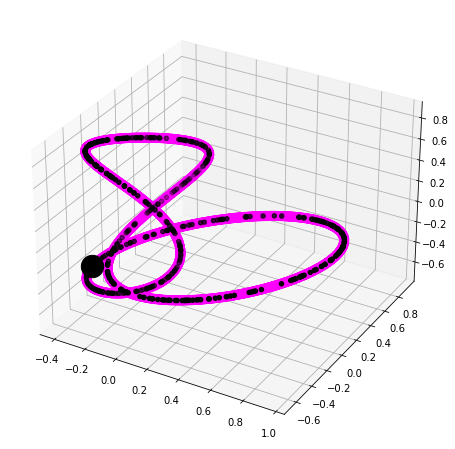

----> Optimization problem via Grassmann <----
Frequencies ((1, 2, 3),) - result 4.5999057541323233e-07
The optimal frequencies found is ((1, 2, 3),) with cost 4.5999057541323233e-07
Non-symmetric Hausdorff distance from X to estimated orbit: 0.03420812750109557 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.06987844630187955


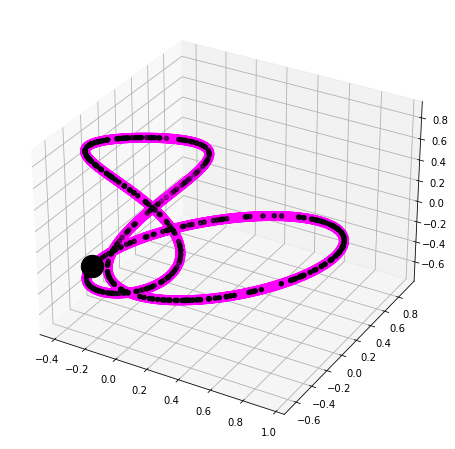

----> Optimization problem via NormalForm <----
Frequencies in normal form decomposition: (0.267547501981226, 0.5347916171519234, 0.8015087400693996)
The optimal frequencies found is  ((1, 2, 3),) with cost  0.0004795776186066098
Non-symmetric Hausdorff distance from X to estimated orbit: 0.034208818462282506 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.06987901471001133


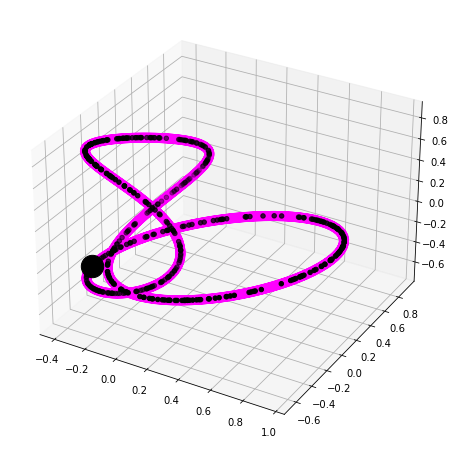

In [90]:
' Lie-PCA '

n_neighbors = 5
method='localPCA'
Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

' Project on Lie subalgebras '

frequency_max = 3
for method in ['Stiefel', 'Grassmann', 'NormalForm']:

    OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(Sigma, dim, ambient_dim, frequency_max=frequency_max, method=method)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 200
    x = X[0,:] #initial point of X
    Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

    # Plot dataset
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=10); plt.show()

## I-2: Representation of $T^2$

### I-2-a: Representation of $T^2$ in $\mathbb{R}^6$

-----> Representation of T^2 in R^6
frequencies: ((1, 2, 2), (2, 1, 2))


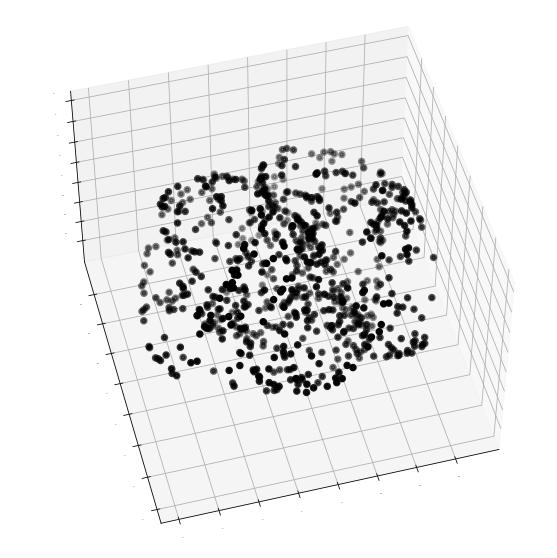

In [67]:
' Generate dataset '

# Parameters
ambient_dim = 6     # ambient dimension
dim = 2             # dimension of the torus 
n_points = 750      # number of sample points
frequency_max = 2   # maximal angle parameter

# Generate dataset and plot
X, LieAlgebra = SampleOnTorus(dim=dim, ambient_dim=ambient_dim, n_points=n_points, frequency_max=frequency_max,
                              conjugate=True,right_multiply=True,verbose=True)
%matplotlib inline
velour.PlotPCA(X); plt.show();

In [68]:
' Check minimal-dimensional subspace '

eps_pca = 1e-10
pca = sklearn.decomposition.PCA(n_components=ambient_dim); pca.fit(X)
print('Minimal subspace has dimension', sum(pca.explained_variance_ratio_>eps_pca))

' Lie-PCA '

n_neighbors = 15
for method in ['localcovariance','localPCA']:
    Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

Minimal subspace has dimension 6
----> Lie PCA with localcovariance estimation of tangent spaces <----
First eigenvalues: [0.007990345766784621, 0.010693952421388481, 0.06291466848510532, 0.06479024587423224]
----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.0018695394416861628, 0.002075993106540842, 0.06855825134303084, 0.0726340312398981]


----> Optimization problem via Stiefel <----
Frequencies ((1, 1, 2), (1, 2, 1)) - result 0.004959611690744729
Frequencies ((1, 1, 2), (1, 2, 2)) - result 0.005687851791934415
Frequencies ((1, 2, 2), (2, 1, 2)) - result 1.8939273178358633e-05
The optimal frequencies found is  ((1, 2, 2), (2, 1, 2)) with cost  1.8939273178358633e-05
Non-symmetric Hausdorff distance from X to estimated orbit: 0.06496304216643836 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.43171051503557817


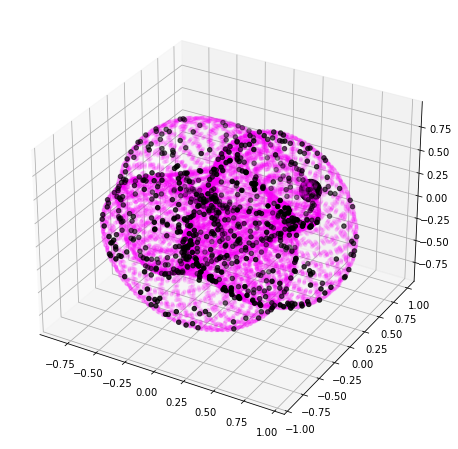

----> Optimization problem via Grassmann <----
Frequencies ((1, 1, 2), (1, 2, 1)) - result 0.6866512148133429
Frequencies ((1, 1, 2), (1, 2, 2)) - result 0.5140831467748747
Frequencies ((1, 2, 2), (2, 1, 2)) - result 0.0007365562989440277
The optimal frequencies found is ((1, 2, 2), (2, 1, 2)) with cost 0.0007365562989440277
Non-symmetric Hausdorff distance from X to estimated orbit: 0.051637340564095344 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.4398610103914967


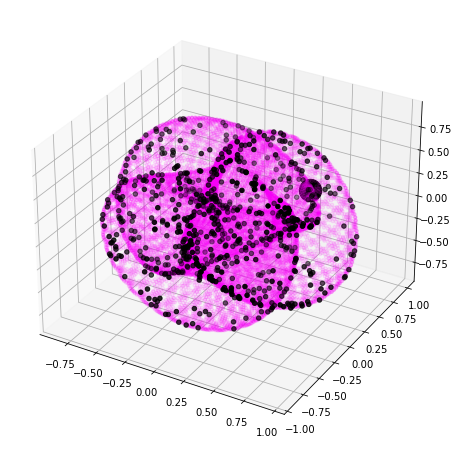

----> Optimization problem via NormalForm <----
Test commutation: 0.008761779047956816
The optimal frequencies found is ((2, -1, 2), (2, -2, 1)) cost: 0.020652474716229826
              ---> equivalent to ((1, 2, 2), (2, 1, 2))
Non-symmetric Hausdorff distance from X to estimated orbit: 0.05160572300881014 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.4383948797872609


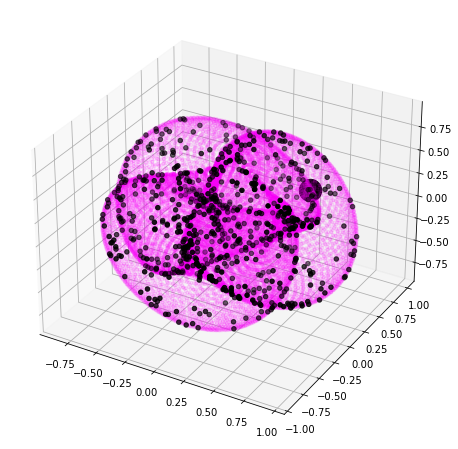

In [69]:
' Project on Lie subalgebras '

for method in ['Stiefel','Grassmann','NormalForm']:
    OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(Sigma,dim,ambient_dim,frequency_max,method=method)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 150
    x = X[0,:] #initial point of X
    Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

    # Plot dataset
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',s=10,alpha=0.1); plt.show();

### I-2-b: Representation of $T^2$ in $\mathbb{R}^8$

-----> Representation of T^2 in R^8
frequencies: ((1, 2, 2, 3), (2, 2, 3, 2))


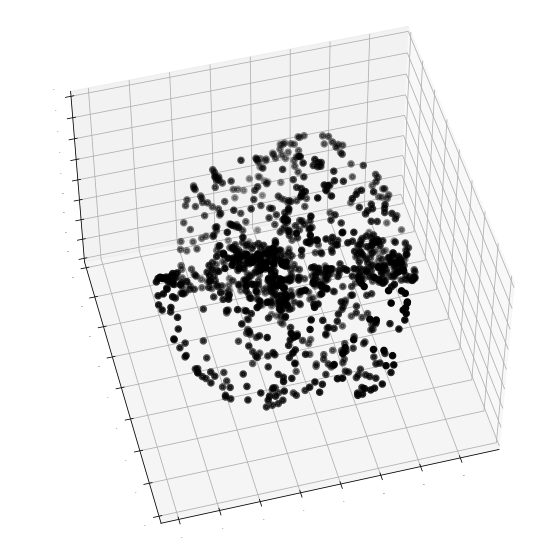

In [61]:
' Generate dataset '

# Parameters
ambient_dim = 8     # ambient dimension
dim = 2             # dimension of the torus 
n_points = 1000      # number of sample points
frequency_max = 3   # maximal angle parameter

# Generate dataset and plot
X, LieAlgebra = SampleOnTorus(dim=dim, ambient_dim=ambient_dim, n_points=n_points, frequency_max=frequency_max,
                              conjugate=False,right_multiply=False,verbose=True)
%matplotlib inline
velour.PlotPCA(X); plt.show();

In [62]:
' Check minimal-dimensional subspace '

eps_pca = 1e-10
pca = sklearn.decomposition.PCA(n_components=ambient_dim); pca.fit(X)
print('Minimal subspace has dimension', sum(pca.explained_variance_ratio_>eps_pca))

' Lie-PCA '

n_neighbors = 15
for method in ['localcovariance','localPCA']:
    Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

Minimal subspace has dimension 8
----> Lie PCA with localcovariance estimation of tangent spaces <----
First eigenvalues: [0.004461937493314937, 0.013014470137292199, 0.03819952839129827, 0.04419430846527745]
----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.001661343363283227, 0.0019509987030137555, 0.04545319160166876, 0.05073625389523684]


**Warning:** The following cell takes a lot of time to run. This is because of the orbit generation, which consists of $200\times 200\times 200$ points.

----> Optimization problem via NormalForm <----
Test commutation: 0.014664374634903209
There are 26496 frequencies to test.
The optimal frequencies found is ((2, -3, 2, -1), (3, -2, 2, -2)) cost: 0.0449227232192434
              ---> equivalent to ((1, 2, 2, 3), (2, 2, 3, 2))
Non-symmetric Hausdorff distance from X to estimated orbit: 0.04483492696368159 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.4893167924470345


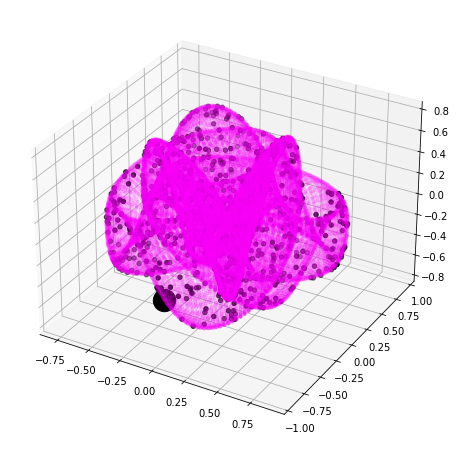

In [63]:
' Project on Lie subalgebras '

#for method in ['Stiefel','Grassmann','NormalForm']:
for method in ['NormalForm']:
    OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(Sigma,dim,ambient_dim,frequency_max,
                                                                  method=method,verbosity=2)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 200
    x = X[0,:] #initial point of X
    Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

    # Plot dataset
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',s=10,alpha=0.1); plt.show();

## I-2: Representation of $T^3$ in $\mathbb{R}^6$

-----> Representation of T^3 in R^6
frequencies: ((1, 1, 2), (1, 2, 2), (1, 3, 2))


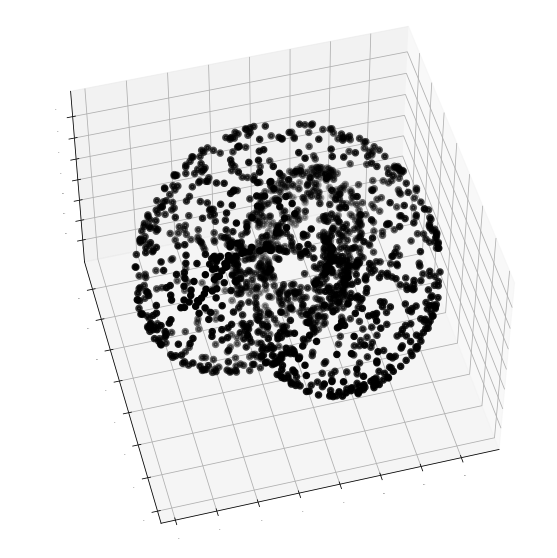

In [70]:
' Generate dataset '

# Parameters
ambient_dim = 6     # ambient dimension
dim = 3             # dimension of the torus 
n_points = 1500     # number of sample points
frequency_max = 3   # maximal angle parameter

# Generate dataset and plot
right_multiply = False
X, LieAlgebra = SampleOnTorus(dim=dim, ambient_dim=ambient_dim, n_points=n_points, frequency_max=frequency_max, 
                              conjugate=False, right_multiply=False, verbose=True)
%matplotlib inline
velour.PlotPCA(X); plt.show();

In [71]:
' Check minimal-dimensional subspace '

eps_pca = 1e-10
pca = sklearn.decomposition.PCA(n_components=ambient_dim); pca.fit(X)
print('Minimal subspace has dimension', sum(pca.explained_variance_ratio_>eps_pca))

' Lie-PCA '

n_neighbors = 15
for method in ['localcovariance','localPCA']:
    Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

Minimal subspace has dimension 6
----> Lie PCA with localcovariance estimation of tangent spaces <----
First eigenvalues: [-0.03402847738251129, -0.02933024622749831, 0.04936077194715305, 0.053578752205559584]
----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.00031637232497874854, 0.00032371612938128215, 0.01874924761573477, 0.02054714614369433]


In [72]:
' Project on Lie subalgebras '

#for method in ['Stiefel','Grassmann','NormalForm']:
for method in ['NormalForm']:
    OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(Sigma,dim,ambient_dim,frequency_max,
                                                                  method=method,verbosity=2)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 150
    x = X[0,:] #initial point of X
    Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

#     # Plot dataset
#     pca = sklearn.decomposition.PCA(n_components=3)
#     Xpca = pca.fit_transform(X)
#     fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
#     ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
#     ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

#     # Plot estimated orbit
#     Orbitpca = pca.transform(Orbit)
#     ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',s=10,alpha=0.1); plt.show();

----> Optimization problem via NormalForm <----
Test commutation: 0.014126421344437267
There are 432 frequencies to test.
The optimal frequencies found is ((2, 1, 1), (3, 1, 3), (2, 3, 2)) cost: 6.199131567892908e-16
              ---> equivalent to ((1, 1, 2), (1, 3, 3), (3, 2, 2))
Non-symmetric Hausdorff distance from X to estimated orbit: 0.03623208691428242 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.7818638140422023


# Experiments II: pixels permutations

## Experiment II-1: linear images

We consider a set of $1\times n$ images obtained by applying cyclic permutations to the vector [1,1,0,...,0].
We obtain a dataset of $n$ images.

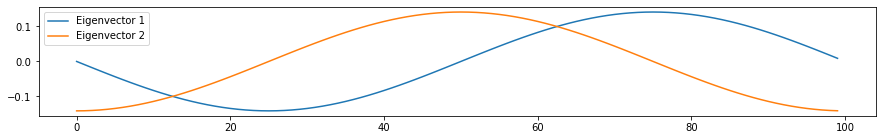

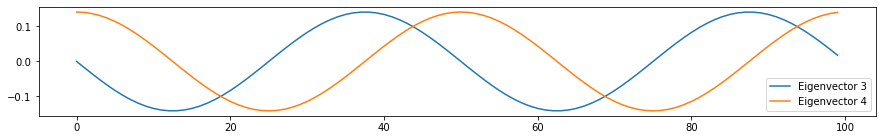

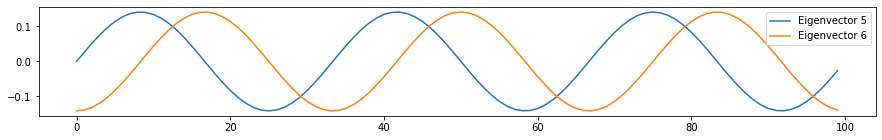

In [26]:
' Generate 1xn images '

n = 100
x0 = np.zeros((n)); 
x0[0] = 1; x0[1] = 1;
X = [np.roll(x0, i) for i in range(n)]

' Plot the eigenvectors of PCA '

pca = sklearn.decomposition.PCA(n_components=n); pca.fit(X)
#print('PCA explained variance:', pca.explained_variance_ratio_)

for I in range(3):
    plt.figure(figsize=(15,2))
    for i in range(2): plt.plot(pca.components_[2*I+i])
    plt.legend(['Eigenvector '+repr(2*I+1),'Eigenvector '+repr(2*I+2)])

In [27]:
' Generate dataset '

# Parameters
ambient_dim = 8     # dimension to reduce the dataset
dim = 1              # dimension of the torus (here, circle)

# PCA
pca = sklearn.decomposition.PCA(n_components=ambient_dim); 
X = pca.fit_transform(X)

In [28]:
' Lie-PCA '

n_neighbors = 5
# method='localcovariance'
# Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

method='localPCA'
Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.0012394874774651807, 0.034211670323723936, 0.03524250225641637, 0.05733312542107113]


----> Optimization problem via NormalForm <----
Frequencies in normal form decomposition: (0.19012738150162356, 0.3758526328253391, 0.5532857714240789, 0.7186523723896409)
The optimal frequencies found is  ((1, 2, 3, 4),) with cost  0.018389472412201107
Non-symmetric Hausdorff distance from X to estimated orbit: 0.031121317402089448 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.054387749640361735


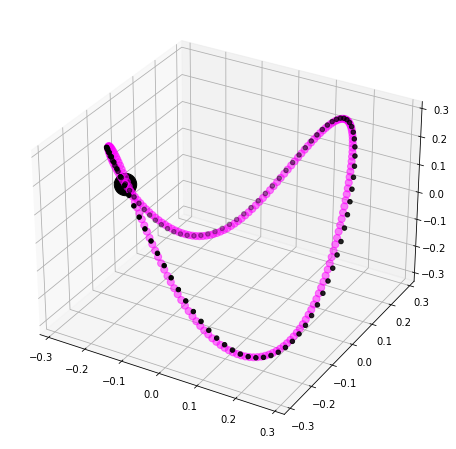

In [29]:
' Project on Lie subalgebras '

frequency_max = 10

#for method in ['Stiefel','Grassmann','NormalForm']:
for method in ['NormalForm']:
    OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(Sigma,dim,ambient_dim,frequency_max,
                                                                  method=method,verbosity=2)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 200
    x = X[0,:] #initial point of X
    Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

    # Plot dataset
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',s=50,alpha=0.5); plt.show();

We observe the following interesting phenomenon: the frequencies form the integer progression 1, 2, 3, 4, ...
This has to do with circle Fourier series. Note that if we increase the value of **ambient_dim**, we will see this pattern going on.

## Experiment II-2: $\mathbb{S}^1$ action on translated gorillas

In [30]:
' Generate dataset '

# Parameter
pas = 7

# Open file
file = "./RotatingImages/gorilla_white.png"
pic = plt.imread(file)
pic = pic[::pas,::pas,0:3]
pic = pic[7:137,9:130]

shape = np.shape(pic)
x = np.shape(pic)[0]
y = np.shape(pic)[1]
print('shape:', shape)

# Translate image
X = []
x2, y2 = int(x/2), int(y/2)
X = np.zeros((x2,x*y*3))
for i in range(x2):
    pic2 = np.roll(pic, 2*i, 0)
    X[i] = pic2.flatten()
        
# Save dataset as a .npy file
np.save('RotatingImages/gorilla_circle.npy', X)

shape: (130, 120, 3)


shape X: (65, 46800)


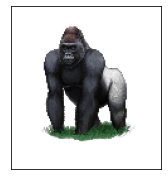

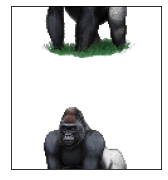

In [31]:
' Open dataset '

X = np.load('RotatingImages/gorilla_circle.npy')
print('shape X:', np.shape(X))

shape = tuple([130, 120, 3])
x, y = shape[0], shape[1]
N1 = 65; 
len_img = 130*120*3

# Plot some images of the dataset
for i in np.linspace(0, N1, 3)[:-1]:
    i = int(i)
    plt.figure(figsize=(3,3))
    plt.imshow(X[i].reshape(shape))
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)

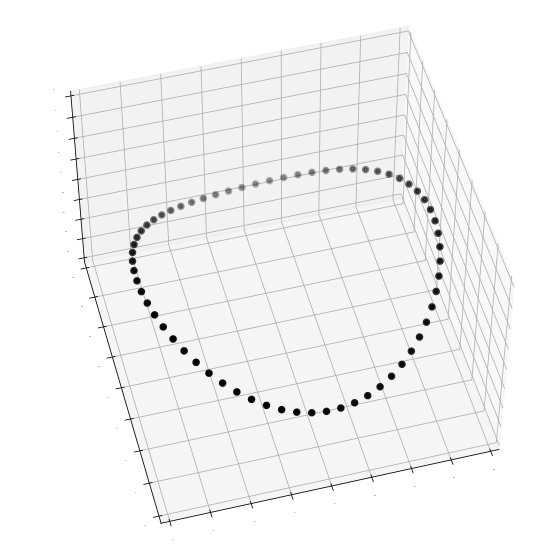

In [32]:
' Generate dataset '

# Parameters
dim = 1             # dimension of the torus (here, circle)
frequency_max = 3   # maximal angle parameter

# PCA
dim_pca = 6
ambient_dim = dim_pca
pca = sklearn.decomposition.PCA(n_components=dim_pca)
X = pca.fit_transform(X)

# Normalize
for i in range(np.shape(X)[0]): X[i,:] /= np.linalg.norm(X[i,:])

# Plot PCA
velour.PlotPCA(X); plt.show();

In [33]:
' Lie-PCA '

n_neighbors = 5
# method='localcovariance'
# Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

method='localPCA'
Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.0005940167554437421, 0.01817104204020753, 0.018277573006072263, 0.018834860867844954]


----> Optimization problem via NormalForm <----
Frequencies in normal form decomposition: (0.278082924848838, 0.5477791980697841, 0.789055027909676)
The optimal frequencies found is  ((1, 2, 3),) with cost  0.021327659096450687
Non-symmetric Hausdorff distance from X to estimated orbit: 0.026066898561068818 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.06684897727796663


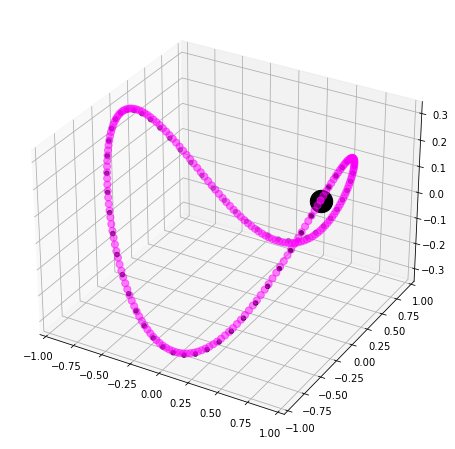

In [34]:
' Project on Lie subalgebras '

frequency_max = 10

#for method in ['Stiefel','Grassmann','NormalForm']:
for method in ['NormalForm']:
    OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(Sigma,dim,ambient_dim,frequency_max,
                                                                  method=method,verbosity=2)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 200
    x = X[0,:] #initial point of X
    Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

    # Plot dataset
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',s=50,alpha=0.5); plt.show();

## Experiment II-3: $\mathbb{T}^2$ action on translated gorillas

In [35]:
' Generate dataset '

# Parameter
pas = 7

# Open file
file = "./RotatingImages/gorilla_white.png"
pic = plt.imread(file)
pic = pic[::pas,::pas,0:3]
pic = pic[7:137,9:130]

shape = np.shape(pic)
x = np.shape(pic)[0]
y = np.shape(pic)[1]
print('shape:', shape)

# Translate image
X = []
x2, y2 = int(x/2), int(y/2)
X = np.zeros((x2,y2,x*y*3))
for i in range(x2):
    for j in range(y2):
        pic2 = np.roll(pic, 2*i, 0)
        pic2 = np.roll(pic2, 2*j, 1)
        X[i,j] = pic2.flatten()
        

# Save dataset
np.save('RotatingImages/gorilla_torus.npy', X)

shape: (130, 120, 3)


shape X: (65, 60, 46800)


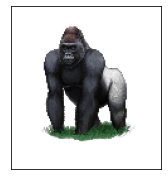

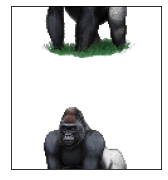

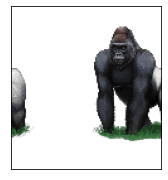

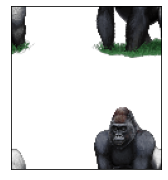

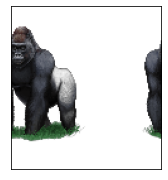

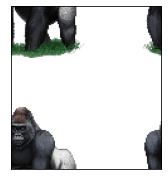

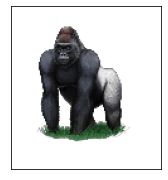

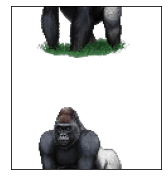

In [36]:
' Open dataset '

X = np.load('RotatingImages/gorilla_torus.npy')
print('shape X:', np.shape(X))

shape = tuple([130, 120, 3])
x = shape[0]; y = shape[1]
N1 = 65; N2 = 60
N = 3900
len_img = 130*120*3

# Plot some images of the dataset
for j in list(np.linspace(0, N2, 4)[:-1])+[N2-2]:
    for i in np.linspace(0, N1, 3)[:-1]:
        j = int(j); i = int(i)
        plt.figure(figsize=(3,3))
        plt.imshow(X[i,j].reshape(shape))
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_visible(False)
        
# Normalize dataset
X = X.reshape((N, len_img))
X = X/max([np.linalg.norm(X[i]) for i in range(np.shape(X)[0])])

Rips Complex is of dimension 2 - 1154400 simplices - 3900 vertices. Filtration maximal value is 0.15.


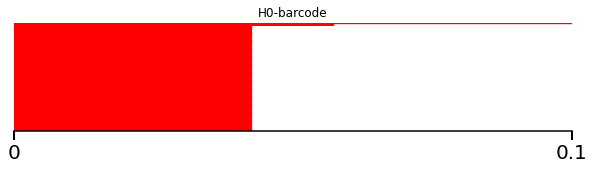

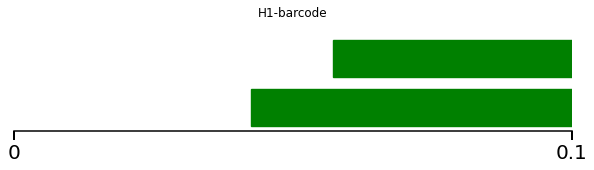

In [37]:
' Persistent homology '

# Rips filtration
dimension_max = 2  
st = velour.RipsComplex(X, filtration_max = 0.15, dimension_max = dimension_max)   #Rips filtration of X
velour.PlotPersistenceBarcodes(st, tmax=0.15, d=dimension_max-1, eps=0.03, homology_coeff_field=2)         #persistence of Rips filtration

PCA explained variance: [0.15163591 0.15163591 0.09496319 0.09496319 0.0718314  0.0718314 ]


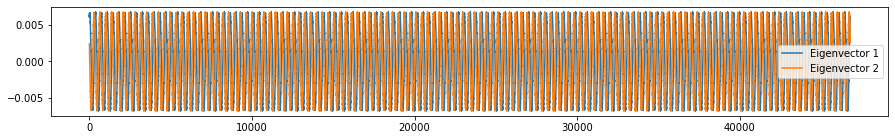

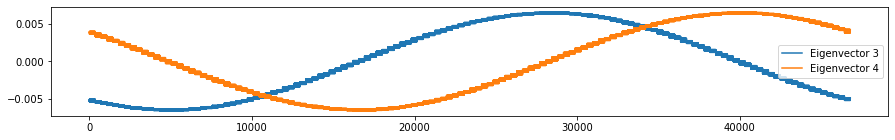

In [38]:
' Plot the eigenvectors of PCA '

n = 6

pca = sklearn.decomposition.PCA(n_components=n); pca.fit(X)
print('PCA explained variance:', pca.explained_variance_ratio_)

for I in range(2):
    plt.figure(figsize=(15,2))
    for i in range(2): plt.plot(pca.components_[2*I+i])
    plt.legend(['Eigenvector '+repr(2*I+1),'Eigenvector '+repr(2*I+2)])

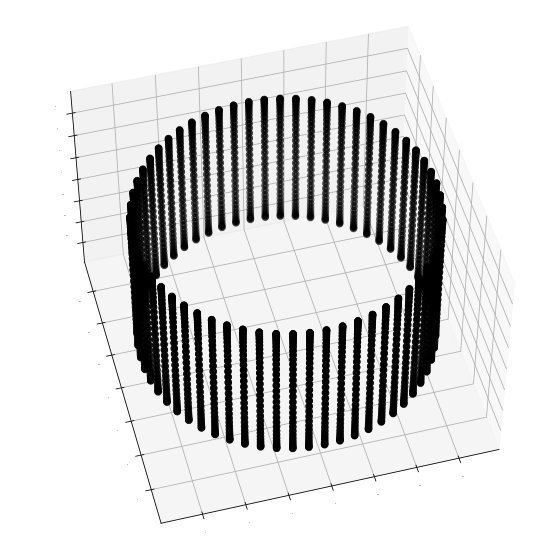

In [39]:
' Generate dataset '

# Parameters
dim = 2             # dimension of the torus (here, circle)
frequency_max = 4   # maximal angle parameter

# PCA
dim_pca = 6
ambient_dim = dim_pca
pca = sklearn.decomposition.PCA(n_components=dim_pca)
X = pca.fit_transform(X)

# Normalize dataset
for i in range(np.shape(X)[0]): X[i,:] /= np.linalg.norm(X[i,:])

# Plot PCA
velour.PlotPCA(X); plt.show();

In [40]:
' Lie-PCA '

n_neighbors = 15
# method='localcovariance'
# Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

method='localPCA'
Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [1.0685339183216742e-13, 5.194594359707563e-05, 0.06169468931829047, 0.06170377471783963]


----> Optimization problem via NormalForm <----
Test commutation: 0.0002720749770573636
There are 1728 frequencies to test.
The optimal frequencies found is ((2, 3, -1), (1, 3, -2)) cost: 0.00042062655978490464
              ---> equivalent to ((1, 2, 3), (2, 1, 3))
Non-symmetric Hausdorff distance from X to estimated orbit: 0.04490329632666137 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.047977027222980494


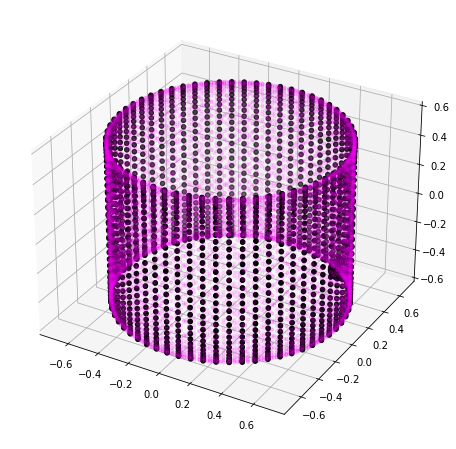

In [41]:
' Project on Lie subalgebras '

dim = 2            
frequency_max = 3

#for method in ['Stiefel','Grassmann','NormalForm']:
for method in ['NormalForm']:
    OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(Sigma,dim,ambient_dim,frequency_max,
                                                                  method=method,verbosity=2)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 100
    x = X[0,:] #initial point of X
    Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

    # Plot dataset
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',s=10,alpha=0.1); plt.show();

## Experiment II-4: $\mathbb{S}^1$ action on arrows

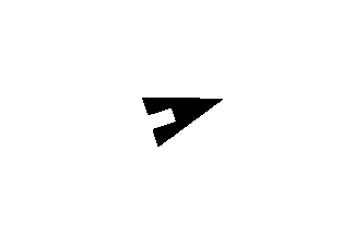

(200, 300)

In [42]:
' Generate dataset '

N_images = 200

import os

if os.path.isdir('tempDir') == False: os.mkdir('tempDir') 

def rgb2gray(rgb): return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

for value in range(0, N_images):
    fig, ax = plt.subplots()
    ax.arrow(0.5,0.5,0.3*np.cos(np.pi*value/100),0.3*np.sin(np.pi*value/100), width = 0.1, length_includes_head = True, 
             head_width = 0.3, color = 'black') #make the arrows centered at 0.5x0.5 and rotate them in a full turn in intervals
                                                # of 360/20 degrees
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.gca().set_aspect('equal', adjustable='box') #make scale of axes as similar as possible
    plt.axis('off')  
    plt.savefig('tempDir/'+'rot'+str(value)+'.png', dpi=50) #dpi controls the number of pixels used
    plt.close() 
    
# Plot an image
image = plt.imread('tempDir/'+'rot10.png')
gray = rgb2gray(image)    
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.axis('off')
plt.show()
np.shape(gray)

In [43]:
' Open dataset '

rot_dataset = []
for value in range(0,N_images):
    image = plt.imread('tempDir/'+'rot'+str(value)+'.png')
    gray = rgb2gray(image)    
    plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.axis('off')
    np.shape(gray)
    rot_dataset.append(gray.reshape(-1))
    plt.close() 
    
print('Shape: ', np.shape(rot_dataset))
X = rot_dataset
X=np.array(X)

Shape:  (200, 60000)


In [44]:
# Normalize (optional)
for i in range(np.shape(X)[0]): X[i,:] /= np.linalg.norm(X[i,:])

PCA explained variance: [0.12931896 0.12898257 0.07507855 0.0740869  0.06986972 0.06980879
 0.0617434  0.06158555 0.02399309 0.0239601 ]


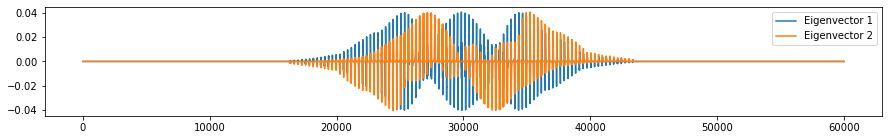

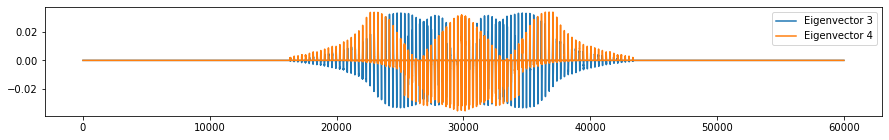

In [45]:
' Plot the eigenvectors of PCA '

n = 10

pca = sklearn.decomposition.PCA(n_components=n); pca.fit(X)
print('PCA explained variance:', pca.explained_variance_ratio_)

for I in range(2):
    plt.figure(figsize=(15,2))
    for i in range(2): plt.plot(pca.components_[2*I+i])
    plt.legend(['Eigenvector '+repr(2*I+1),'Eigenvector '+repr(2*I+2)])

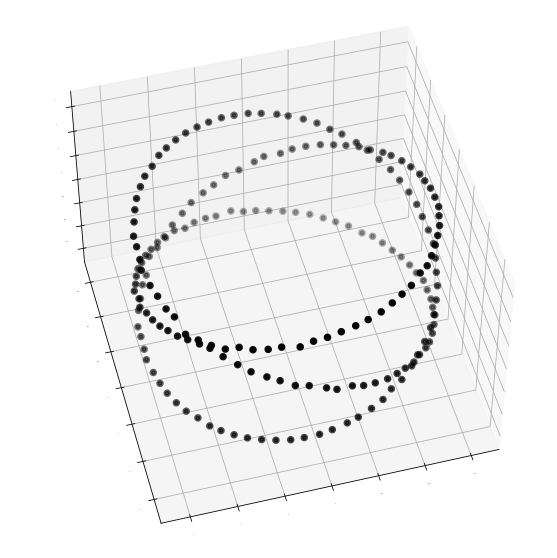

In [46]:
' Generate dataset '

# Parameters
dim = 1             # dimension of the torus (here, circle)
frequency_max = 6   # maximal angle parameter

# PCA
dim_pca = 8
ambient_dim = dim_pca
pca = sklearn.decomposition.PCA(n_components=dim_pca)
X = pca.fit_transform(X)

# Normalize
for i in range(np.shape(X)[0]): X[i,:] /= np.linalg.norm(X[i,:])

# Plot PCA
velour.PlotPCA(X); plt.show();

In [47]:
' Lie-PCA '

n_neighbors = 5
# method='localcovariance'
# Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

method='localPCA'
Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.0004870744724893081, 0.041929513508922114, 0.04223619619849603, 0.045377862523690596]


----> Optimization problem via NormalForm <----
Frequencies in normal form decomposition: (0.16167531262258056, 0.3244210356650396, 0.4839166530429556, 0.7965153845432729)
The optimal frequencies found is  ((1, 2, 3, 5),) with cost  0.007016682620580272
Non-symmetric Hausdorff distance from X to estimated orbit: 0.03076353480701353 
Non-symmetric Hausdorff distance from estimated orbit to X: 0.05710174676794682


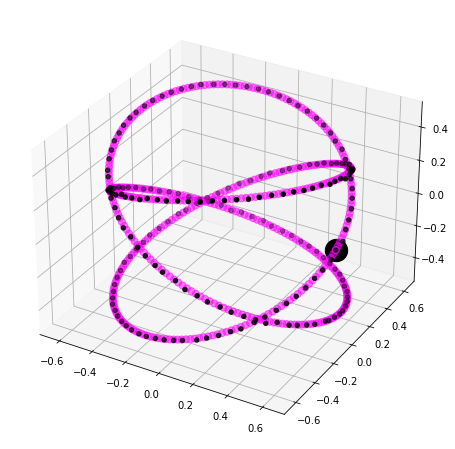

In [48]:
' Project on Lie subalgebras '

dim = 1            
frequency_max = 15

#for method in ['Stiefel','Grassmann','NormalForm']:
for method in ['NormalForm']:
    OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra(Sigma,dim,ambient_dim,frequency_max,
                                                                  method=method,verbosity=2)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 500
    x = X[0,:] #initial point of X
    Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x)

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('\x1b[1;31m'+'Non-symmetric Hausdorff distance from X to estimated orbit:', Hausdorff,'\x1b[0m')
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', Hausdorff)

    # Plot dataset
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=500)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.scatter(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',s=50,alpha=0.5); plt.show();

# Experiments III - $SO(3)$